In [1]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

import lightning as pl # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme


import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

BATCH_SIZE = 1#256 if torch.cuda.is_available() else 48
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
print(device)
num_workers = 7 # Set to your device

import json

torch.set_float32_matmul_precision('medium')

cuda:0


In [2]:
data_transforms_none = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToTensor()
])

def norm_stats(ds):
    L=len(ds)
    mean_total = np.zeros(3)
    std_total = np.zeros(3)
    for i in range(L):
        img = (ds.__getitem__(i))[0].numpy()
        img = img.reshape(img.shape[0],img.shape[1]*img.shape[2])

        mean_total += np.mean(img,axis=1)
        std_total += np.std(img,axis=1)

    means = (mean_total/L).tolist()
    stds = (std_total/L).tolist()

    return means, stds    

In [2]:
# We will use modular convolutional blocks. 
# Define a convolutional layer along with an activation function
# Remember, you can use other techniques you have learnt from the lectures and workshops such as dropout, batchnorm, pooling etc.

class ConvBlock(nn.Module):

    def __init__(self, channels_in, channels_out,stride=1):
        super(ConvBlock, self).__init__()     # Call constructor
        middle_channel = (channels_in+channels_out)//2
        # print(middle_channel)
        self.conv1 = nn.Conv2d(in_channels=channels_in,out_channels=middle_channel, kernel_size=3,stride=stride)
        self.conv2 = nn.Conv2d(in_channels=middle_channel,out_channels=channels_out, kernel_size=3,stride=stride)
        self.activ = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2)
        #self.batchnorm1 = nn.BatchNorm2d(middle_channel)
        #self.batchnorm2 = nn.BatchNorm2d(channels_out)

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool(x)
        x = self.activ(x)

        x = self.conv2(x)
        x = self.activ(x)
        return x



In [3]:
for crossval_idx in [1,2,3,4]:
    # train_ds = torchvision.datasets.ImageFolder(f"./data/imgs/train{crossval_idx}/",transform=data_transforms_none)
    # means, stds = norm_stats(train_ds)
    # print("Mean",means, " Std",stds)

    means = [0.66, 0.53, 0.27]
    stds = [0.13, 0.17, 0.31]

    data_transforms = transforms.Compose([
        # Convert the image to a PyTorch tensor
        transforms.ToTensor(),
        transforms.Normalize(means,stds)
    ])

    train_set = torchvision.datasets.ImageFolder(f"./data/imgs/train{crossval_idx}/",transform=data_transforms)
    val_set = torchvision.datasets.ImageFolder(f"./data/imgs/val{crossval_idx}/",transform=data_transforms)
    test_set = torchvision.datasets.ImageFolder(f"./data/imgs/test/",transform=data_transforms)

    # Create Dataloaders again with features generated from pre-trained CNN model
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, persistent_workers=True)
    valid_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, persistent_workers=True)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)#, persistent_workers=True)

    
    #Let's create a simple CNN for image classification
    class Simple_CNN(pl.LightningModule):
        def __init__(self, num_classes=6, learning_rate=1e-3):
            super().__init__()
            
            self.learning_rate = learning_rate
            self.num_classes = num_classes
            self.criterion = nn.CrossEntropyLoss()
            
            # Initialise at least 2 convolutional blocks with
            self.conv_blk1 = ConvBlock(3, 8,stride = 2)
            self.conv_blk2 = ConvBlock(8,16,stride = 2)
            
            # You can use other layers too, feel free to define them here
            self.pool = nn.MaxPool2d(2)
            self.gap = nn.AdaptiveAvgPool2d(output_size=20)
            self.dropout = nn.Dropout(0.1)
            
            # You will need to define your fully connected layer:
            self.fc1 = nn.Linear(16*20*20,100)
            self.fc2 = nn.Linear(100,64)
            self.fc3 = nn.Linear(64, num_classes)

            self.leaky_relu = nn.LeakyReLU()
            
            # Define your accuracies        
            self.train_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
            self.val_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
            self.test_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
            
            
        def forward(self, x):
            x = self.dropout(x)
            x = self.conv_blk1(x)
            x = self.pool(x)
            x = self.dropout(x)
            x = self.conv_blk2(x)
            x = self.gap(x)

            x = torch.flatten(x,start_dim=1)
            x = self.dropout(x)
            x = self.leaky_relu(self.fc1(x))
            # x = self.dropout(x)
            x = self.leaky_relu(self.fc2(x))
            x = self.dropout(x)
            x = self.leaky_relu(self.fc3(x))

            return x
        
        def training_step(self, batch, batch_idx):
            x, y= batch
            logits = self(x)
            loss = self.criterion(logits, y)

            # Compute accuracy
            preds = logits.argmax(1)
            self.train_accuracy.update(preds, y)
            acc = self.train_accuracy.compute()

            # Record accuracy and loss
            # Log anything you think necessary
            train_dict = {"train_loss": loss,
                        "train_acc": acc,
                        "epoch": self.current_epoch}
            
            self.log_dict(train_dict, prog_bar=True, on_step=False, on_epoch=True)

            return loss

        def validation_step(self, batch, batch_idx):
            x, y= batch
            logits = self(x)
            loss = self.criterion(logits, y)

            # Compute accuracy
            preds = logits.argmax(1)
            self.val_accuracy.update(preds, y)
            acc = self.val_accuracy.compute()

            # Record accuracy and loss
            # Log anything you think necessary
            val_dict = {"val_loss": loss,
                        "val_acc": acc,
                        "epoch": self.current_epoch}
            
            self.log_dict(val_dict, prog_bar=True, on_step=False, on_epoch=True)
        
            

        def test_step(self, batch, batch_idx):
            x, y= batch
            logits = self(x)
            loss = self.criterion(logits, y)

            # Compute accuracy
            preds = logits.argmax(1)
            self.test_accuracy.update(preds, y)
            acc = self.test_accuracy.compute()

            # Record accuracy and loss
            # Log anything you think necessary
            test_dict = {"test_loss": loss,
                        "test_acc": acc,
                        "epoch": self.current_epoch}
            
            self.log_dict(test_dict, prog_bar=True, on_step=False, on_epoch=True)

            return preds, logits, x, y
        
        def predict_step(self, batch, batch_idx):
            x, y= batch
            logits = self(x)
            loss = self.criterion(logits, y)

            # Compute accuracy
            preds = logits.argmax(1)
            self.test_accuracy.update(preds, y)

            return preds, logits, x, y

            

        def configure_optimizers(self):
            optimizer = torch.optim.Adam(self.parameters(),self.learning_rate)
            return optimizer

        ##########
        # DATA RELATED HOOKS
        ##########

        def train_dataloader(self):
            return train_loader
        def val_dataloader(self):
            return valid_loader
        def test_dataloader(self):
            return test_loader
    
    # Initialize the CNN model
    max_epochs = 15 # Feel free to change this
    model_cnn = Simple_CNN()

    # Initialize checkpoint callback to save the best model using validation loss
    checkpoint_callback = ModelCheckpoint(
            monitor="val_loss",
            dirpath=f"checkpoints_section/v2_{crossval_idx}/",
            save_top_k=1,        
            mode="min",
            every_n_epochs=1
        )

    # Call the Trainer and train the model
    early_stopping = EarlyStopping('val_loss', patience = 10, mode = 'min')

    trainer_task = pl.Trainer(
        accelerator="auto",#"cpu",
        devices=1, #if torch.cuda.is_available() else None,  # limiting got iPython runs
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback,early_stopping],
        logger=CSVLogger(save_dir=f"logs_task/v2_{crossval_idx}/"),
        precision=32
    )

    trainer_task.fit(model_cnn)

    torch.save(model_cnn,f"./models/v2_{crossval_idx}/model_0.pt")

GPU available: True (cuda), used: True


5
12


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type               | Params
-------------------------------------------------------
0  | criterion      | CrossEntropyLoss   | 0     
1  | conv_blk1      | ConvBlock          | 508   
2  | conv_blk2      | ConvBlock          | 2.6 K 
3  | pool           | MaxPool2d          | 0     
4  | gap            | AdaptiveAvgPool2d  | 0     
5  | dropout        | Dropout            | 0     
6  | fc1            | Linear             | 640 K 
7  | fc2            | Linear             | 6.5 K 
8  | fc3            | Linear             | 390   
9  | leaky_relu     | LeakyReLU          | 0     
10 | train_accuracy | MulticlassAccuracy | 0     
11 | val_accuracy   | MulticlassAccuracy | 0     
12 | test_accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------------
650 K     Trainable params
0    

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\result.py:212: UserWarning: You called `self.log('epoch', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

c:\Users\shelb\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\result.py:212: UserWarning: You called `self.log('epoch', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type               | Params
-------------------------------------------------------
0  | criterion      | CrossEntropyLoss   | 0     
1  | conv_blk1      | ConvBlock          | 508   
2  | conv_blk2      | ConvBlock          | 2.6 K 
3  | pool           | MaxPool2d          | 0     
4  | gap            | AdaptiveAvgPool2d  | 0     
5  | dropout        | Dropout            | 0     
6  | fc1            | Linear             | 640 K 
7  | fc2            | Linear             | 6.5 K 
8  | fc3            | Linear             | 390   
9  | leaky_relu     | LeakyReLU          | 0     
10 | train_accuracy | MulticlassAccuracy | 0     
11 | val_accuracy   | MulticlassAccuracy | 0     
12 | test_accuracy  | MulticlassAccuracy | 0     
-

5
12


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type               | Params
-------------------------------------------------------
0  | criterion      | CrossEntropyLoss   | 0     
1  | conv_blk1      | ConvBlock          | 508   
2  | conv_blk2      | ConvBlock          | 2.6 K 
3  | pool           | MaxPool2d          | 0     
4  | gap            | AdaptiveAvgPool2d  | 0     
5  | dropout        | Dropout            | 0     
6  | fc1            | Linear             | 640 K 
7  | fc2            | Linear             | 6.5 K 
8  | fc3            | Linear             | 390   
9  | leaky_relu     | LeakyReLU          | 0     
10 | train_accuracy | MulticlassAccuracy | 0     
11 | val_accuracy   | MulticlassAccuracy | 0     
12 | test_accuracy  | MulticlassAccuracy | 0     
-

5
12


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [10]:
# model_cnn = Simple_CNN.load_from_checkpoint("./checkpoints_section/v2_1/epoch=7-step=310056.ckpt")
# [{'test_loss': 0.6088061332702637,
#   'test_acc': 0.8497371673583984,
#   'epoch': 15.0}]


# model_cnn = Simple_CNN.load_from_checkpoint("./checkpoints_section/v2_2/epoch=13-step=545832.ckpt")
# [{'test_loss': 0.6471614241600037,
#   'test_acc': 0.8639932870864868,
#   'epoch': 15.0}]

# model_cnn = Simple_CNN.load_from_checkpoint("./checkpoints_section/v2_3/epoch=6-step=262962.ckpt")
# [{'test_loss': 0.6130478382110596,
#   'test_acc': 0.863520085811615,
#   'epoch': 15.0}]

# model_cnn = Simple_CNN.load_from_checkpoint("./checkpoints_section/v2_4/epoch=14-step=600030.ckpt")
# [{'test_loss': 0.64957594871521,
#   'test_acc': 0.8480377197265625,
#   'epoch': 15.0}]

model_cnn.eval()
trainer_task.test(model_cnn,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


5
12


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           epoch           │           15.0            │
│         test_acc          │    0.8480377197265625     │
│         test_loss         │     0.64957594871521      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.64957594871521,
  'test_acc': 0.8480377197265625,
  'epoch': 15.0}]

14


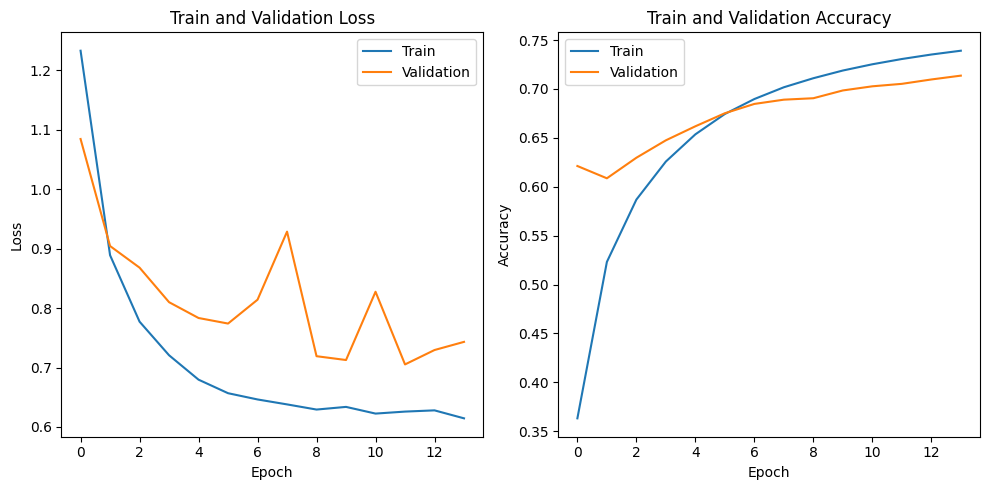

In [6]:
METRICS_PATH = "./logs_task/v2_4/lightning_logs/version_1"
metrics_task = pd.read_csv(METRICS_PATH + "/metrics.csv")
metrics_task.set_index("epoch", inplace=True)
metrics_task = metrics_task.groupby(level=0).sum().drop("step", axis=1)

plt.rcParams["figure.figsize"] = (10, 5)

plt.subplot(1,2,1)
epochs = len(metrics_task)-1
print(epochs)
plt.plot(metrics_task["train_loss"][0:epochs-1])
plt.plot(metrics_task["val_loss"][0:epochs-1])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train and Validation Loss")
plt.legend(["Train", "Validation"]);

plt.subplot(1,2,2)

plt.plot(metrics_task["train_acc"][0:epochs-1])
plt.plot(metrics_task["val_acc"][0:epochs-1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Train and Validation Accuracy")
plt.legend(["Train", "Validation"]);

plt.tight_layout();

In [3]:
#GradCAM
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

In [26]:
def filenames(self, indices=[], basename=False):
        if indices: 
            # grab specific indices
            if basename:
                return [os.path.basename(self.imgs[i][0]) for i in indices]
            else:
                return [self.imgs[i][0] for i in indices]
        else:
            if basename:
                return [os.path.basename(x[0]) for x in self.imgs]
            else:
                return [x[0] for x in self.imgs]
            
torchvision.datasets.ImageFolder.filenames = filenames      


def saliencylowmem(testset,test_dfs, model ,plot=False,save_plot=False, force_index = None, track_stats=False, track_stats2=False):
    #Keep memory usage low by get each prediction individually and perform stats at runtime
    # Square Stats
    # 0 - Bench (X) 0/1
    # 1 - Pot 0/1
    # 2 - Onion Source 0/1
    # 3 - Dish Source 0/1
    # 4 - Serving 0/1
    # 5 - Player 1
    # 6 - Player 2
    # 7 - None/Empty space

    square_stats = None
    square_stats2 = []
    if track_stats != False:
        square_stats = np.zeros([track_stats,8])

    for idx in range(len(testset)):
        if force_index is not None: #Allows a specified index for analysis/debugging
            idx = force_index
        item = testset.__getitem__(idx)

        # Retrieve the input image, true label
        image_original = item[0]
        label = item[1]
        # print(testset.filenames([idx]))
        global_index = None
        try:
            global_index = testset.filenames([idx])[0].split("\\")[1].split(".")[0]
        except IndexError:
            print(idx)
            continue
        # print(global_index)

        # Add a batch dimension to the input image (via .unsqueeze()) and set requires_grad to True for saliency analysis
        image = image_original.unsqueeze(0).clone().to(device)
        # print(image.shape)
        image.requires_grad = True

        # Compute the scores and gradients for the input image
        # To compute the scores, do a forward pass of the image and then take the argmax
        # Use this index to extract the score_max value from "scores"
        # Then perform a backward step so that it backpropagates the gradient
        model.eval()
        scores = model.forward(image)
        score_max_index = torch.argmax(scores)

        pred = score_max_index

        score_max = scores[0, score_max_index]
        score_max.backward() # Do the backward step here for the gradient calculation

        # Calculate the saliency map by finding the maximum absolute gradient values across channels
        # You can use .abs() and torch.max()
        grad = image.grad.to("cpu")
        grad_abs = torch.squeeze(grad.abs())
        grad_max = torch.max(grad_abs,dim=0).values

        #Get state from pandas files
        #Ensure corrected ids test set is used
        row = test_dfs.iloc[int(global_index)]
        map_layout = row['layout']
        map_layout = map_layout.replace("\'","\"").replace("1"," ").replace("2"," ")
        map_layout = json.loads(map_layout)

        map_shape = (len(map_layout),len(map_layout[0]))
        # print(map_shape)
        grad_abs_sml = transforms.functional.resize(grad_abs, map_shape, interpolation = torchvision.transforms.InterpolationMode.BICUBIC, antialias= True)
        grad_max_sml = torch.max(grad_abs_sml,dim=0).values


        #Unnormalise Image for display
        clean_img = []
        for ch in range(3):
            ch_layer = image_original[ch]
            corrected_layer = ch_layer*stds[ch]+means[ch]
            clean_img.append(corrected_layer.abs())
        clean_img = torch.tensor(np.array(clean_img)).permute(1,2,0)
        clean_img = np.array(clean_img)



        #Downscaling and then upscaling gradient image for smooth interpretation
        scale_factor = 3
        grad_abs_med = transforms.functional.resize(grad_abs, (map_shape[0]*scale_factor, map_shape[1]*scale_factor), interpolation = torchvision.transforms.InterpolationMode.BICUBIC, antialias= True)
        grad_max_med = torch.max(grad_abs_med,dim=0).values
        up_down_grad_max = transforms.functional.resize(grad_max_med.unsqueeze(0), (grad_max.shape[0],grad_max.shape[1]), interpolation = torchvision.transforms.InterpolationMode.BICUBIC, antialias= True).squeeze().abs()
        up_down_max = torch.max(up_down_grad_max)
        up_down_grad_max = (up_down_grad_max/(up_down_max.item()))
        grad_max_image = show_cam_on_image(clean_img, up_down_grad_max, use_rgb=True)

        # GradCAM results (Does not look right for CNN2 (very large patches of saliency without detail))
        # model = model_cnn
        # model.eval()
        # targets = [ClassifierOutputTarget(label)] #0-5
        # target_layers = [model.conv_blk2.conv2]
        # with GradCAM(model=model, target_layers=target_layers) as cam:
        #     grayscale_cams = cam(input_tensor=image, targets=targets)
        #     cam_image = show_cam_on_image(clean_img, grayscale_cams[0, :], use_rgb=True)
        # cam = np.uint8(255*grayscale_cams[0, :])
        # cam = cv2.merge([cam, cam, cam])

        #For top k salient tile(s) tracking stats
        if track_stats != False:
            track_topk = torch.topk(grad_max_sml.reshape(-1),track_stats)
            track_indices = track_topk.indices
            # print(track_topk)
            for track_idx in range(track_stats):
                max_idx = track_indices[track_idx]

                # max_pos = (((grad_max_sml==torch.max(grad_max_sml)).nonzero()).squeeze()) #singular max value (replaced with allowance for top k max values)
                max_pos = (max_idx//map_shape[1],max_idx%map_shape[1])
                # print(max_pos , (max_idx//map_shape[1],max_idx%map_shape[1]) , max_idx)
                max_item = map_layout[max_pos[0]][max_pos[1]]

                #Sort
                item_list = ['X','P','O','D','S']
                found = False
                for item_idx in range(len(item_list)):
                    target_item = item_list[item_idx]
                    if max_item==target_item:
                        square_stats[track_idx,item_idx]+=1
                        found = True
                        break
                if found == False:
                    state = json.loads(row['state'])
                    player_idx = row['player_idx']
                    p_idx = 5 #location for square stats counting

                    for player in [state['players'][player_idx], state['players'][(player_idx+1)%2]]:
                        #Position
                        player_pos = torch.tensor([player['position'][1],player['position'][0]]) #Corrected for rows then cols
                        # print(player_pos,max_pos)
                        if player_pos[0] == max_pos[0] and player_pos[1] == max_pos[1]:
                            square_stats[track_idx,p_idx]+=1
                            found=True
                            break
                        else:
                            p_idx+=1
                if found == False:
                    square_stats[track_idx,7]+=1

        #For individual ranking stats
        if track_stats2 != False:
            track_topk = torch.topk(grad_max_sml.reshape(-1),map_shape[0]*map_shape[1])
            track_indices = track_topk.indices

            stat2 = []
            for max_idx in track_indices:
                max_pos = (max_idx//map_shape[1],max_idx%map_shape[1])
                max_item = map_layout[max_pos[0]][max_pos[1]]

                if max_item == " ":
                    found = False
                    p_idx= 1
                    state = json.loads(row['state'])
                    player_idx = row['player_idx']

                    for player in [state['players'][player_idx], state['players'][(player_idx+1)%2]]:
                        #Position
                        player_pos = torch.tensor([player['position'][1],player['position'][0]]) #Corrected for rows then cols
                        # print(player_pos,max_pos)
                        if player_pos[0] == max_pos[0] and player_pos[1] == max_pos[1]:
                            found=True
                            break
                        else:
                            p_idx+=1
                    if found == True:
                        max_item = str(p_idx)
                    else:
                        max_item = "E"
                
                if max_item not in stat2:
                    stat2.append(max_item)
                
                if len(stat2)==8:
                    break
            square_stats2.append(stat2)
            

        # # Create a subplot to display the original image and saliency map side by side
        if plot or save_plot:
            # images = np.hstack((cam , cam_image))
            # grad_cam = Image.fromarray(images)
            actions_list = ["INT","Right","Left","Down","Up",]
            plt.close()
            plt.figure()

            # Create a subplot to display the original image and saliency map side by side
            plt.rcParams["figure.figsize"] = (10, 9)
            plt.subplot(2,2,1)
            plt.imshow(grad_max)
            plt.title(f"Saliency (Max)\nPred: {actions_list[pred]}, GT: {actions_list[label]}, Index: {global_index}")
            plt.axis('off')

            #Downsampled saliency
            plt.subplot(2,2,4)
            plt.imshow(grad_max_sml)
            plt.title(f"Downsized Saliency\nPred: {actions_list[pred]}, GT: {actions_list[label]}, Index: {global_index}")
            plt.axis('off')

            #Downsampled then upsampled overlay
            plt.subplot(2,2,3)
            plt.imshow(grad_max_image)
            plt.title(f"Smoothened Overlay\nPred: {actions_list[pred]}, GT: {actions_list[label]}, Index: {global_index}")
            plt.axis('off')

            #Original Image
            plt.subplot(2,2,2)
            plt.title(f"Original (Blue)\nPred: {actions_list[pred]}, GT: {actions_list[label]}, Index: {global_index}")
            plt.imshow((clean_img))
            plt.axis('off')

            plt.tight_layout()

            if plot:
                plt.show()
                print("Probabilities:",torch.nn.functional.softmax(scores))

            if save_plot:
                plt.savefig(fname=f"./results/v2_2/{global_index}.png")

        if force_index is not None:
            return square_stats, square_stats2

    return square_stats, square_stats2

In [17]:
test_dfs = pd.read_pickle("./data/test_data.pickle").reset_index()

In [ ]:
model_cnn = Simple_CNN.load_from_checkpoint("./checkpoints_section/v2_1/epoch=7-step=310056.ckpt")
crossval_idx=1
# [{'test_loss': 0.6088061332702637,
#   'test_acc': 0.8497371673583984,
#   'epoch': 15.0}]


# model_cnn = Simple_CNN.load_from_checkpoint("./checkpoints_section/v2_2/epoch=13-step=545832.ckpt")
# crossval_idx=2
# [{'test_loss': 0.6471614241600037,
#   'test_acc': 0.8639932870864868,
#   'epoch': 15.0}]

# model_cnn = Simple_CNN.load_from_checkpoint("./checkpoints_section/v2_3/epoch=6-step=262962.ckpt")
# crossval_idx=3
# [{'test_loss': 0.6130478382110596,
#   'test_acc': 0.863520085811615,
#   'epoch': 15.0}]

# model_cnn = Simple_CNN.load_from_checkpoint("./checkpoints_section/v2_4/epoch=14-step=600030.ckpt")
# crossval_idx=4
# [{'test_loss': 0.64957594871521,
#   'test_acc': 0.8480377197265625,
#   'epoch': 15.0}]

test_dfs = pd.read_pickle("./data/test_data.pickle").reset_index()
square_stats, square_stats2 = saliencylowmem(test_set,test_dfs, model=model_cnn,plot=False,save_plot=False,track_stats=5, track_stats2=True)

ss1_arr = np.array(square_stats )
ss2_arr = np.array(square_stats2)
np.save(f"./results/v2_{crossval_idx}/square_stats.npy",ss1_arr)
np.save(f"./results/v2_{crossval_idx}/ranks.npy",ss2_arr)
# print(square_stats)

In [27]:
for crossval_idx in [1,2,3,4]:
    # train_ds = torchvision.datasets.ImageFolder(f"./data/imgs/train{crossval_idx}/",transform=data_transforms_none)
    # means, stds = norm_stats(train_ds)
    # print("Mean",means, " Std",stds)
    path=None
    if crossval_idx == 1:
        path = "./checkpoints_section/v2_1/epoch=7-step=310056.ckpt"
    elif crossval_idx == 2:
        path = "./checkpoints_section/v2_2/epoch=13-step=545832.ckpt"
    elif crossval_idx == 3:
        path = "./checkpoints_section/v2_3/epoch=6-step=262962.ckpt"
    elif crossval_idx == 4:
        path = "./checkpoints_section/v2_4/epoch=14-step=600030.ckpt"
    else:
        print("Ignored CrossVal Index", crossval_idx)
        continue

    means = [0.66, 0.53, 0.27]
    stds = [0.13, 0.17, 0.31]

    data_transforms = transforms.Compose([
        # Convert the image to a PyTorch tensor
        transforms.ToTensor(),
        transforms.Normalize(means,stds)
    ])

    # train_set = torchvision.datasets.ImageFolder(f"./data/imgs/train{crossval_idx}/",transform=data_transforms)
    val_set = torchvision.datasets.ImageFolder(f"./data/imgs/val{crossval_idx}/",transform=data_transforms)
    test_set = torchvision.datasets.ImageFolder(f"./data/imgs/test/",transform=data_transforms)
    
    #Let's create a simple CNN for image classification
    class Simple_CNN(pl.LightningModule):
        def __init__(self, num_classes=6, learning_rate=1e-3):
            super().__init__()
            
            self.learning_rate = learning_rate
            self.num_classes = num_classes
            self.criterion = nn.CrossEntropyLoss()
            
            # Initialise at least 2 convolutional blocks with
            self.conv_blk1 = ConvBlock(3, 8,stride = 2)
            self.conv_blk2 = ConvBlock(8,16,stride = 2)
            
            # You can use other layers too, feel free to define them here
            self.pool = nn.MaxPool2d(2)
            self.gap = nn.AdaptiveAvgPool2d(output_size=20)
            self.dropout = nn.Dropout(0.1)
            
            # You will need to define your fully connected layer:
            self.fc1 = nn.Linear(16*20*20,100)
            self.fc2 = nn.Linear(100,64)
            self.fc3 = nn.Linear(64, num_classes)

            self.leaky_relu = nn.LeakyReLU()
            
            # Define your accuracies        
            self.train_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
            self.val_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
            self.test_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
            
            
        def forward(self, x):
            x = self.dropout(x)
            x = self.conv_blk1(x)
            x = self.pool(x)
            x = self.dropout(x)
            x = self.conv_blk2(x)
            x = self.gap(x)

            x = torch.flatten(x,start_dim=1)
            x = self.dropout(x)
            x = self.leaky_relu(self.fc1(x))
            # x = self.dropout(x)
            x = self.leaky_relu(self.fc2(x))
            x = self.dropout(x)
            x = self.leaky_relu(self.fc3(x))

            return x
        
        def training_step(self, batch, batch_idx):
            x, y= batch
            logits = self(x)
            loss = self.criterion(logits, y)

            # Compute accuracy
            preds = logits.argmax(1)
            self.train_accuracy.update(preds, y)
            acc = self.train_accuracy.compute()

            # Record accuracy and loss
            # Log anything you think necessary
            train_dict = {"train_loss": loss,
                        "train_acc": acc,
                        "epoch": self.current_epoch}
            
            self.log_dict(train_dict, prog_bar=True, on_step=False, on_epoch=True)

            return loss

        def validation_step(self, batch, batch_idx):
            x, y= batch
            logits = self(x)
            loss = self.criterion(logits, y)

            # Compute accuracy
            preds = logits.argmax(1)
            self.val_accuracy.update(preds, y)
            acc = self.val_accuracy.compute()

            # Record accuracy and loss
            # Log anything you think necessary
            val_dict = {"val_loss": loss,
                        "val_acc": acc,
                        "epoch": self.current_epoch}
            
            self.log_dict(val_dict, prog_bar=True, on_step=False, on_epoch=True)
        
            

        def test_step(self, batch, batch_idx):
            x, y= batch
            logits = self(x)
            loss = self.criterion(logits, y)

            # Compute accuracy
            preds = logits.argmax(1)
            self.test_accuracy.update(preds, y)
            acc = self.test_accuracy.compute()

            # Record accuracy and loss
            # Log anything you think necessary
            test_dict = {"test_loss": loss,
                        "test_acc": acc,
                        "epoch": self.current_epoch}
            
            self.log_dict(test_dict, prog_bar=True, on_step=False, on_epoch=True)

            return preds, logits, x, y
        
        def predict_step(self, batch, batch_idx):
            x, y= batch
            logits = self(x)
            loss = self.criterion(logits, y)

            # Compute accuracy
            preds = logits.argmax(1)
            self.test_accuracy.update(preds, y)

            return preds, logits, x, y

            

        def configure_optimizers(self):
            optimizer = torch.optim.Adam(self.parameters(),self.learning_rate)
            return optimizer

        ##########
        # DATA RELATED HOOKS
        ##########

        def train_dataloader(self):
            return train_loader
        def val_dataloader(self):
            return valid_loader
        def test_dataloader(self):
            return test_loader
    
    model_cnn = Simple_CNN.load_from_checkpoint(path)

    test_dfs = pd.read_pickle("./data/test_data.pickle").reset_index()
    val_dfs = pd.read_pickle(f"./data/val{crossval_idx}.pickle").reset_index()


    square_stats, square_stats2 = saliencylowmem(val_set,val_dfs, model=model_cnn,plot=False,save_plot=False,track_stats=5, track_stats2=True)
    # square_stats, square_stats2 = saliencylowmem(test_set,test_dfs, model=model_cnn,plot=False,save_plot=False,track_stats=5, track_stats2=True)

    ss1_arr = np.array(square_stats )
    ss2_arr = np.array(square_stats2)
    # np.save(f"./results/v2_{crossval_idx}/square_stats.npy",ss1_arr)
    # np.save(f"./results/v2_{crossval_idx}/ranks.npy",ss2_arr)

    np.save(f"./results/v2_{crossval_idx}/square_stats_val.npy",ss1_arr)
    np.save(f"./results/v2_{crossval_idx}/ranks_val.npy",ss2_arr)


